# 2. Sampling and Quantisation

This series of notebooks will introduce two important processes used in digital systems:
**sampling** and **quantisation**.

A digital system has limitations in memory and processing power, therefore discretising a signal in time (sampling) and amplitude (quantisation) is neccessary. 

In [1]:
# To be moved

import matplotlib.pyplot as plt
from scipy import signal
import numpy as np

def plot_timeseries(x, y, title=None, **kwargs):
    plt.figure(figsize=(10,4))
    ax = plt.gca()
    ax.set_xlabel('Time (s)')
    ax.set_ylabel('Amplitude')
    ax.grid(True)
    
    if title is None:
        ax.set_title('Timeseries')
    else:
        ax.set_title(title)
    
    ax.plot(x, y, **kwargs)  
    
    return ax

def compare_timeseries(x1, y1, x2, y2, title):
    plt.figure(figsize=(10,4))
    ax = plt.gca()
    ax.set_xlabel('Time (s)')
    ax.set_ylabel('Amplitude')
    ax.grid(True)
    ax.set_title(title)
    ax.plot(x1, y1)  
    ax.stem(x2, y2,  basefmt='red', linefmt='red', markerfmt='C3o')
    plt.show()

def plot_response(fs, w, h, title):
    "Utility function to plot response functions"
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.plot(0.5*fs*w/np.pi, 20*np.log10(np.abs(h)))
    ax.set_ylim(-40, 5)
    ax.set_xlim(0, 1000)
    ax.grid(True)
    ax.set_xlabel('Frequency (Hz)')
    ax.set_ylabel('Gain (dB)')
    ax.set_title(title)

## 2.1 Sampling

Sampling is traditionally performed by an analogue to digital converter (ADC). The process can be thought of as recording the voltage level of an analogue signal at an instant in time. This sample is assigned a binary number through a process called quantisation - more on that later. By collecting samples at a regular period, we can approximate an analogue signal on a digital system.

<img src="./images/ADC.png" style="width: 650px;"/>

The speed at which an ADC generates binary numbers is called the **sampling rate** or **sampling frequency**, $f_{s}$.

The time between samples is called the **sampling period**, $t_{s}$:

$ t_{s} = 1 / f_{s} $

Sampling frequency is quoted in samples per second, or simply as Hertz (Hz).

The actual sampling rate will depend on parameters of the application.
This may vary from:  
**10’s** of Hz for control systems,  
**100’s** of Hz for biomedical,  
**1000’s** of Hz for audio applications,  
**1,000,000’s** of Hz for IF digital radios,  
**1,000,000,000's** of Hz for RF digital radios.  

This notebook is written for and runs on a digital system and therefore we cannot truthfully generate a continuous analogue signal. However, for the purposes of this notebook, we can approximate one by sampling it at a high rate. 

In the following cell we will create a "continuous" sine wave of frequency 100 Hz. The formula for generating a sine wave is:

$ y(t) = Asin(2\pi ft + \phi) $

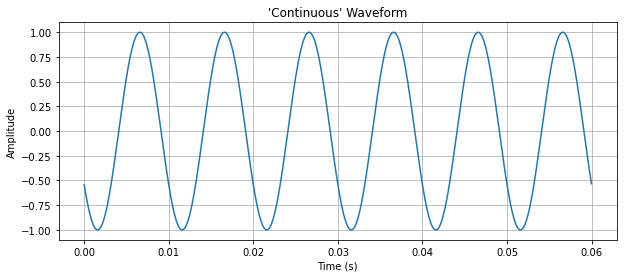

In [2]:
A = 1       # Amplitude
f = 100     # Desired frequency 
t = 0.06    # Time

fs = 48000  # A high sample rate to approximate a continuous signal

x_cont = np.arange(0, t, 1/fs)                     # Discrete time i.e. sampled time period
y_cont = A * np.sin(2 * np.pi * f * x_cont + 10)   # Formula for sine wave

ax = plot_timeseries(x_cont, y_cont, "'Continuous' Waveform")

## 2.2 Sampling - How Fast?

In order to ensure that we retain **all** of the information in the signal, what **sampling rate** should be used? 

<img src="./images/sampler.png" style="width: 650px;"/>

Below, we will sample the "continuous" 100 Hz signal at various sample rates and inspect the results.

Sampling at $f_{s}$=100 Hz, i.e. 1 sample per period:

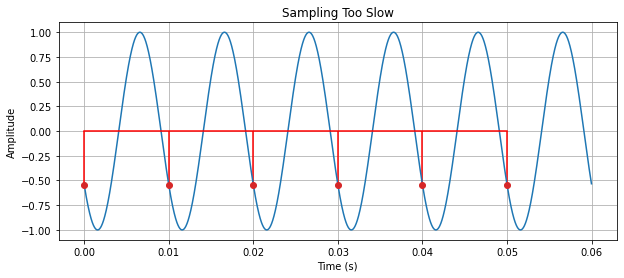

In [3]:
A = 1       # Amplitude
f = 100     # Desired frequency 
t = 0.06    # Time

fs = 100    # 100 Hz (1 sample per period)

x = np.arange(0, t, 1/fs)                # Discrete time i.e. sampled time period
y = A * np.sin(2 * np.pi * f * x + 10)   # Formula for sine wave

compare_timeseries(x_cont, y_cont, x, y, "Sampling Too Slow")

The signal here is interpreted as DC with an offset of -0.54 V. 

Sampling at $f_{s}$=80 Hz, i.e. 1 sample every 0.8 of a period:

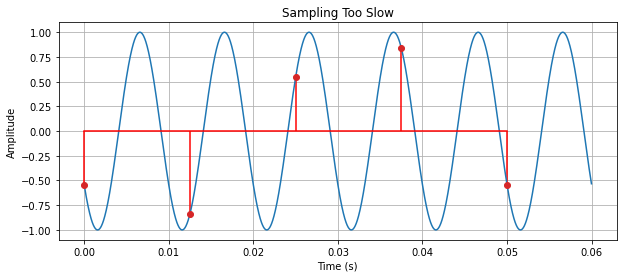

In [4]:
A = 1       # Amplitude
f = 100     # Desired frequency 
t = 0.06    # Time

fs = 80    # 80 Hz (1 sample every 0.8 of a period)

x = np.arange(0, t, 1/fs)                # Discrete time i.e. sampled time period
y = A * np.sin(2 * np.pi * f * x + 10)   # Formula for sine wave

compare_timeseries(x_cont, y_cont, x, y, "Sampling Too Slow")

Most of the signal features here are "missed". In both of these instances, the sampling rate is too slow to record enough of the signal's information to accurately reconstruct. 

Sampling at $f_{s}$=800 Hz, i.e. 8 samples per period:

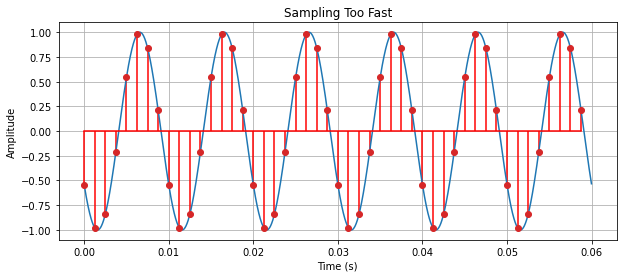

In [5]:
A = 1       # Amplitude
f = 100     # Desired frequency 
t = 0.06    # Time

fs = 800    # 800 Hz (8 samples per period)

x = np.arange(0, t, 1/fs)                # Discrete time i.e. sampled time period
y = A * np.sin(2 * np.pi * f * x + 10)   # Formula for sine wave

compare_timeseries(x_cont, y_cont, x, y, "Sampling Too Fast")

This appears to be a "reasonable" sample rate. 

Sampling at $f_{s}$=3000 Hz, i.e. 30 samples per period:

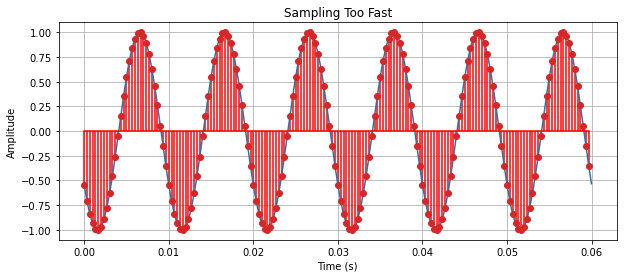

In [6]:
A = 1       # Amplitude
f = 100     # Desired frequency 
t = 0.06    # Time

fs = 3000    # 3000 Hz (30 samples per period)

x = np.arange(0, t, 1/fs)                # Discrete time i.e. sampled time period
y = A * np.sin(2 * np.pi * f * x + 10)   # Formula for sine wave

compare_timeseries(x_cont, y_cont, x, y, "Sampling Too Fast")

Perhaps this rate is higher than necessary.

Sampling too high will better approximate the original signal, however more samples will require more processing. So what is a "suitable" sampling rate? 

From mathematical theory, the minimum sampling rate required to retain all information is referred to as the **Nyquist frequency/rate**:

$f_{n}\ge 2 \times f_{max} $

where $f_{max}$ is the maximum frequency component of a **baseband**, **bandlimited** signal.

**Baseband:** The lowest signal frequency present is around 0 Hz:
<img src="./images/baseband.png" style="width: 600px; vertical-align: middle;"/>

**Bandlimited:** For all frequencies in the signal $f_{l}<f<f_h$:
<img src="./images/bandlimited.png" style="width: 600px; vertical-align: middle;"/>

## 2.4 Reproducing an Analogue Signal
We can see how various sampling rates are interpreted by recontucting the sampled signal. Reconstruction is performed when converting a signal from the digital domain into analogue. A digital to analogue converter (DAC) will hold the voltage value for a period of $ t_s$ for each of the samples giving a "steppy" signal. 

<img src="./images/DAC.png" style="width: 650px;"/>

To model the signal reconstruction performed by a DAC, we can apply a zero order hold (ZOH) to the digital signal. The function below acheives this, given an input signal and a sampling frequency. 

The zero order hold function below first makes the signal "continuous" by zero padding the array to a rate of 48000 Hz - the rate we use to approximate an analogue signal in this notebook. This padded signal is then convolved with the impulse response of ZOH, which is a rectangular window of length, $ t_s $. 

In [7]:
def zero_order_hold(signal, fs):
    # New time axis for 'continuous' signal
    x_zoh = np.arange(0, len(signal)/fs, 1/48000)
    
    # Zero pad the original signal to new rate
    y_zoh = np.zeros(len(x_zoh))
    y_zoh[::int(np.ceil(48000/fs))] = signal
    
    # Create ZOH impulse response and convolve with input signal
    h_zoh = np.ones(int(48000/fs))
    y_zoh = np.convolve(h_zoh,y_zoh)
    
    # Chop of end to match time axis length
    y_zoh = y_zoh[0:len(x_zoh)] 
    
    return x_zoh, y_zoh 

Try changing the sampling rate to see the different outputs from the ZOH.

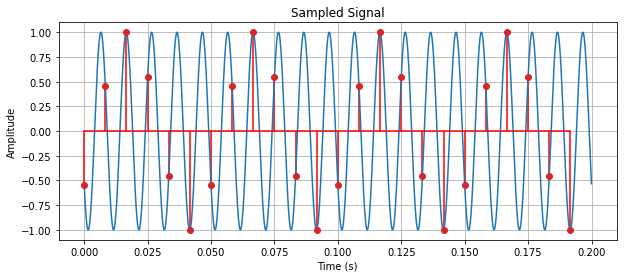

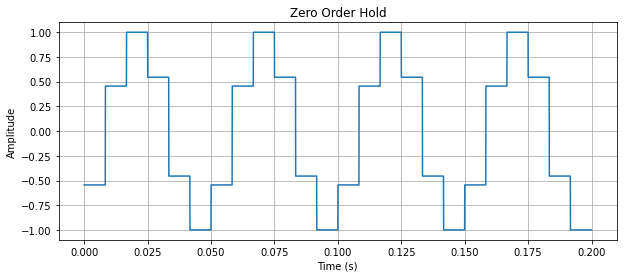

In [8]:
A = 1       # Amplitude
f = 100     # Desired frequency 
t = 0.2    # Time
fs = 120    # Sampling rate

# Define 'continuous' signal for comparison
x_cont = np.arange(0, t, 1/48000)            
y_cont = A * np.sin(2 * np.pi * f * x_cont + 10)  

# Sampled signal
x = np.arange(0, t, 1/fs)                # Discrete time i.e. sampled time period
y = A * np.sin(2 * np.pi * f * x + 10)   # Formula for sine wave

compare_timeseries(x_cont, y_cont, x, y, "Sampled Signal")

# Perform ZOH on sampled signal
[x_zoh, y_zoh] = zero_order_hold(y, fs)
ax = plot_timeseries(x_zoh, y_zoh, title="Zero Order Hold")

Note that the output is a little “steppy” caused by the zero order hold (step reconstruction). This artefact can however be removed with a **reconstruction filter**.

A reconstruction filter is implemented after the DAC with analogue circuitry. It removes the baseband image high frequencies present in the signal (in the form of the steps between the discrete levels).

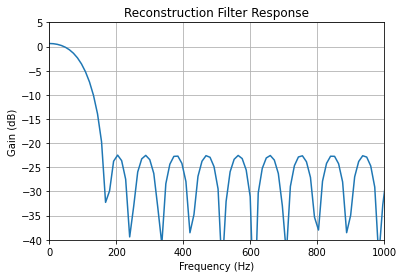

In [9]:
analogue_rate = 48000

# b = signal.firwin(512, 100, fs=48000, window='blackman')
# w, h = signal.freqz(b,1)

cutoff = fs/2      # Desired cutoff frequency, Hz
trans_width = 100  # Width of transition from pass band to stop band, Hz
numtaps = 512      # Size of the FIR filter.
taps = signal.remez(numtaps, 
                    [0, cutoff, cutoff + trans_width, 0.5*analogue_rate], 
                    [1, 0], 
                    Hz=analogue_rate)
w, h = signal.freqz(taps, [1], worN=2000)

plot_response(analogue_rate, w, h, 'Reconstruction Filter Response')

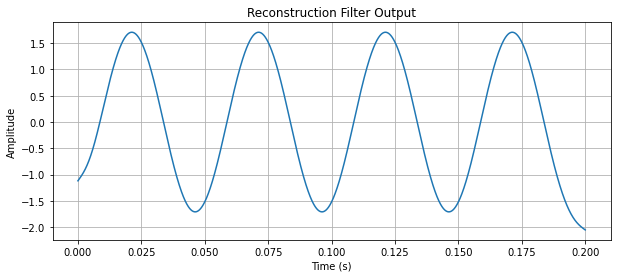

In [10]:
[x_zoh, y_zoh] = zero_order_hold(y, fs)

y_recon = signal.filtfilt(taps, 1, y_zoh)
y_recon = signal.filtfilt(taps, 1, y_recon)
y_recon = signal.filtfilt(taps, 1, y_recon)
y_recon = signal.filtfilt(taps, 1, y_recon)
y_recon = signal.filtfilt(taps, 1, y_recon)

ax = plot_timeseries(x_zoh, y_recon, title="Reconstruction Filter Output")

## 2.5 Nyquist Sampling Rate

## 2.6 Aliasing